In [97]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

# Práctica 1 - Aprendizaje automático
### Grupo 1463
---------

* Pablo Marcos Manchón
* Dionisio Pérez Alvear

In [189]:
# Importamos Librerias
import numpy as np
import collections
from abc import ABCMeta,abstractmethod
from scipy.stats import norm

import matplotlib.pyplot as plt

#from sklearn import datasets
import sklearn.naive_bayes as nb
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold

Definición de la clase ***Datos*** implementada en la práctica 0.

Hemos añadido unas pocas variaciones respecto al diseño original:
* Al inicializar puede especificarse el tipo de datos con el que se guarda la matriz de datos (atributo cast).


* Métodos `__len__` , `__getitem__` y `__yield__` sobrecargados para utilizar de forma mas cómoda la clase.


* El método `extraeDatos` permite indexar por todos los tipos de indices que permite numpy, teniendo en cuenta
  que la información se almacena en una matriz ***nDatos x nAtributos*** (contando el atributo correspondiente a la clase).

El resto de atributos y funciones se encuentran documentados en el código.

In [104]:
class Datos(object):
    """Clase para leer y almacenar los datos de los ficheros .data proporcionados

    Attributes:
        ndatos (int): Numero de entradas de nuestro conjunto de datos
        nAtributos (int): Numero de atributos de cada dato
        nombreAtributos (list): Lista con los nombres de los atributos
        tipoAtributos (list): Lista con string representando el tipo de cada atributo
        nominalAtributos (list): Lista con True en las posiciones de los atributos nominales
        diccionarios (list): Lista de diccionarios con el valor de cada uno de los atributos nominales
        datos (numpy.ndarray) : Matrix ndatosxnAtributos con los datos recolectados y los atributos
            nominales traducidos.
    """

    TiposDeAtributos=('Continuo','Nominal')

    def __init__(self, nombreFichero, cast=None):
        """Constructor de la clase Datos

        Args:
            nombreFichero (str): path del fichero de datos a cargar
            cast (np.dtype, opcional) : Si se especifica la matriz de datos se
                casteara al tipo especificado, en otro caso si todos los atributos
                son nominales se almacenaran en tipo entero y si hay algun dato
                continuo en tipo float.
        """

        # Abrimos el fichero y procesamos la cabecera
        with open(nombreFichero) as f:

            # Guardamos el numero de datos
            self.nDatos = int(f.readline())

            # Guardamos la lista de nombres de atributos
            self.nombreAtributos = f.readline().replace('\n','').split(",")

            # Guardamos la lista de atributos
            self.tipoAtributos = f.readline().replace('\n','').split(",")

            # Numero de atributos
            self.nAtributos = len(self.tipoAtributos)

            # Comprobacion atributos
            if any(atr not in Datos.TiposDeAtributos for atr in self.tipoAtributos):
                raise ValueError("Tipo de atributo erroneo")

            # Guardamos True en las posiciones de atributos nominales
            self.nominalAtributos = [atr == 'Nominal' for atr in self.tipoAtributos]

        # Leemos los datos de numpy en formate string para los datos nominales
        datosNominales = np.genfromtxt(nombreFichero, dtype='S', skip_header=3, delimiter=',')

        # Inicializamos los diccionarios con los distintos valores de los atributos
        self._inicializarDiccionarios(datosNominales)

        # Transformamos los datos nominales en datos numericos empleando los diccionarios
        for i, nominal in enumerate(self.nominalAtributos):
            if nominal:
                datosNominales[:,i] = np.vectorize(self.diccionarios[i].get)(datosNominales[:,i])

        # Convertimos la matriz a tipo numerico, en caso de no especificarse
        # Si todos los atributos son nominales usamos el tipo np.int para ahorrar espacio
        # Si hay datos continuos lo guardamos en tipo np.float
        if cast == None: cast = np.int if all(self.nominalAtributos) else np.float
        self.datos = datosNominales.astype(cast)

        # Convertimos los nombres nominales a string en vez de dejarlos en bytes
        diccionarios_aux = []
        for d in self.diccionarios:
            aux = {}
            for k in d: aux[k.decode('utf-8')] = d[k]
            diccionarios_aux.append(aux)

        self.diccionarios = diccionarios_aux

    def _inicializarDiccionarios(self, datos):
        """Funcion interna para inicializar los diccionarios buscando todos
            los valores que toman los atributos en la matriz de datos"""

        self.diccionarios = []

        for i, nominal in enumerate(self.nominalAtributos):

            if not nominal: # Incluimos diccionarios vacios en los datos no nominales
                self.diccionarios.append({})
            else:
                # Buscamos todos los valores distintos por atributo y creamos el diccionario
                values = np.unique(datos[:,i])
                values.sort()
                self.diccionarios.append({k: v for v, k in enumerate(values)})

    def extraeDatos(self, idx):
        return self.datos[idx]
    
    def __getitem__(self, idx):
        return self.extraeDatos(idx)
    
    def __len__(self):
        return self.nDatos
    
    def __yield__(self):
        for i in range(len(self)):
            yield self.datos[i]

    

***Ejemplo***

Cargamos el dataset balloons el cual se encuentra en la carpeta `../ConjuntosDatos` e imprimimos los datos cargados.


In [113]:
dataset = Datos('../ConjuntosDatos/balloons.data')

print(dataset.datos)

[[1 1 1 0 1]
 [1 1 1 0 1]
 [1 1 1 1 0]
 [1 1 0 0 0]
 [1 1 0 1 0]
 [1 0 1 0 1]
 [1 0 1 0 1]
 [1 0 1 1 0]
 [1 0 0 0 0]
 [1 0 0 1 0]
 [0 1 1 0 1]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 0 0 0]
 [0 1 0 1 0]
 [0 0 1 0 1]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 0 1 0]]


### Apartado 1 - Estrategias de particionado
------

Existen dos clases relativos a las estrategias de particionado:
* Particion: Contiene dos atributos, ***indicesTrain*** correspondientes a los indices de entrenamiento e ***indicesTest*** con los indices de Test de una partición. Para inicializar una partición es suficiente con pasar las dos listas con los indices.


* EstrategiaParticionado: Clase abstracta para las estrategias de particionado, contienen 3 atributos todas las estrategias, ***nombreEstrategia*** con un nombre para imprimir la estrategia, ***numeroParticiones*** y ***partitiones*** una lista con las particiones. Se han sobreargado los métodos `__call__` (para llamar más comodamente a creaParticiones) y `__iter__` (para iterar sobre la lista de particiones de forma transparente). 

In [139]:
class Particion:
  
    def __init__(self, train=[], test=[], name=""):
        self.indicesTrain= train
        self.indicesTest= test
        self.name = name
    
    def __str__(self):
        return "Particion {}:\nTrain: {}\nTest:  {}".format(self.name, 
                                                            str(self.indicesTrain),
                                                            str(self.indicesTest)) 
    
class EstrategiaParticionado:
  
      # Clase abstracta
    __metaclass__ = ABCMeta
  
    def __init__(self, nombre="null"):
        self.nombreEstrategia=nombre
        self.numeroParticiones=0
        self.particiones=[]
        
    def __str__(self):
        return self.nombreEstrategia
    
    def __call__(self, datos):
        return self.creaParticiones(datos)
    
    def __iter__(self):
        for part in self.particiones:
            yield part
  
    @abstractmethod
    # TODO: esta funcion deben ser implementadas en cada estrategia concreta  
    def creaParticiones(self,datos,seed=None):
        pass

### Validación Simple

Implementación de la estrategia de particionado de validación simple.
Esta estrategia crea una partición, en la cual separa en dos conjuntos disjuntos los datos.
Al inicializar se debe indicar el porcentaje de datos a utilizar como entrenamiento, por defecto se usa el 75%.


In [142]:
class ValidacionSimple(EstrategiaParticionado):
    """Crea particiones segun el metodo tradicional 
    de division de los datos segun el porcentaje deseado."""
    
    def __init__(self,porcentaje=.75):

        self.porcentaje = porcentaje
        super().__init__("Validacion Simple con {}% de entrenamiento".format(100*porcentaje))


    def creaParticiones(self, datos, seed=None):    
        np.random.seed(seed)

        self.numeroParticiones = 1

        # Generamos una permutacion de los indices
        indices = np.arange(datos.nDatos)
        np.random.shuffle(indices)

        # Separamos en base al porcentaje necesario
        l = int(datos.nDatos*self.porcentaje)
        self.particiones = [Particion(indices[:l], indices[l:], "simple")]

        return self.particiones

Por ejemplo para inicializar una estrategia de particionado con un 80% de datos de entrenamiento:

In [145]:
# Creamos una particion con validacion simple
validacion_simple = ValidacionSimple(0.8)
particion = validacion_simple(dataset)

# Imprimimos la particion creada (elemento 0 de la lista)
print(validacion_simple)
print(particion[0])

Validacion Simple con 80.0% de entrenamiento
Particion simple:
Train: [13  7  4  8 12 10  6 15  5  1 14 18  3  0 16 17]
Test:  [ 9  2 19 11]


### Validación Cruzada

Implementación de la estrategia de particionado de validación cruzada. Es necesario indicar el número de particiones a crear. Se crearán k bloques y se excluirá uno de ellos en cada partición de los datos de entrenamiento y se utilizará para test.

In [148]:
class ValidacionCruzada(EstrategiaParticionado):
    
    def __init__(self, k=1):
        self.k = k
        super().__init__("Validacion Cruzada con {} particiones".format(k))
  
  # Crea particiones segun el metodo de validacion cruzada.
  # El conjunto de entrenamiento se crea con las nfolds-1 particiones
  # y el de test con la particion restante
  # Esta funcion devuelve una lista de particiones (clase Particion)
    def creaParticiones(self,datos,seed=None):   
        np.random.seed(seed)
        
        self.numeroParticiones = self.k
        # Tam de cada bloque
        l = int(datos.nDatos/self.k)
        
        # Generamos una permutacion de los indices
        indices = np.arange(datos.nDatos)
        np.random.shuffle(indices)
        self.particiones = []
        
        
        for i in range(self.k):

            train = np.delete(indices, range(i*l,(i+1)*l))
            test =  indices[i*l:(i+1)*l-1]
            self.particiones.append(Particion(train, test, i + 1))
                                    
        return self.particiones

***Ejemplo***

Creamos una particion cruzada con 4 bloques.

In [150]:
k=4
validacion_cruzada = ValidacionCruzada(k)
validacion_cruzada(dataset)

print(validacion_cruzada)

# Imprimos las particiones
for particion in validacion_cruzada:
    print(particion)

Validacion Cruzada con 4 particiones
Particion 1:
Train: [ 8  9 19  0 17 10  2  5 16 12  1  6 14 13  7]
Test:  [11  3 15  4]
Particion 2:
Train: [11  3 15  4 18 10  2  5 16 12  1  6 14 13  7]
Test:  [ 8  9 19  0]
Particion 3:
Train: [11  3 15  4 18  8  9 19  0 17  1  6 14 13  7]
Test:  [10  2  5 16]
Particion 4:
Train: [11  3 15  4 18  8  9 19  0 17 10  2  5 16 12]
Test:  [ 1  6 14 13]


### Validacion Bootstrap

Genera particiones de acuerdo a la validación bootstrap.
Es necesario especificar el numero de particiones a la hora de instanciar la clase.

In [151]:
class ValidacionBootstrap(EstrategiaParticionado):
    
    def __init__(self, n):
        super().__init__("Validacion Bootstrap con {} particiones".format(n))
        self.n = n

  # Crea particiones segun el metodo de boostrap
  # Devuelve una lista de particiones (clase Particion)
    def creaParticiones(self,datos,seed=None):    
        np.random.seed(seed)

        self.numeroParticiones = self.n

        # Generamos una permutacion de los indices
        indices = np.arange(datos.nDatos)
        self.particiones = []

        for i in range(self.n):

            # Generamos numeros aleatorios con repeticion
            aleatorios = np.random.randint(0, datos.nDatos, datos.nDatos)
            # Nos quedamos los ejemplos de los indices
            train = indices[aleatorios]
            # Obtenemos los indices que han sido excluidos
            excluidos = [i not in aleatorios for i in indices] 
            
            # El conjunto de indices esta formado por los indices excluidos
            test = indices[excluidos]

            self.particiones.append(Particion(train, test, i+1))

        return self.particiones

***Ejemplo***

Generamos 3 particiones de acuerdo a la estrategia bootstrap

In [152]:
n=3
validacion_bootstrap = ValidacionBootstrap(n)
validacion_bootstrap(dataset)

print(validacion_bootstrap)

# Imprimos las particiones
for particion in validacion_bootstrap:
    print(particion)

Validacion Bootstrap con 3 particiones
Particion 1:
Train: [ 0  4  8 10 13  9 14 14  4 11 12  7  1  8  3  8  0  0  3 18]
Test:  [ 2  5  6 15 16 17 19]
Particion 2:
Train: [16  2 11 19  5 19  9 17  9 18 19  2 12  7 19 17  2  1  4  8]
Test:  [ 0  3  6 10 13 14 15]
Particion 3:
Train: [ 3  0 18 14  2  1  1 16 14  0 17  5 17 12 13 19 12  3  5 13]
Test:  [ 4  6  7  8  9 10 11 15]


Probamos también las estrategias de particionado para el conjunto de datos ***tic-tac-toe*** (No imprimimos las particiones debido al tamaño de estas):

In [157]:
dataset_tic_tac_toe = Datos("../ConjuntosDatos/tic-tac-toe.data")

# Creamos una particion con validacion simple
validacion_simple = ValidacionSimple(0.8)
particion = validacion_simple(dataset_tic_tac_toe)

# Imprimimos la particion creada (elemento 0 de la lista)
print(validacion_simple)
#print(particion[0])

k=4
validacion_cruzada = ValidacionCruzada(k)
validacion_cruzada(dataset_tic_tac_toe)

print(validacion_cruzada)

# Imprimos las particiones
#for particion in validacion_cruzada:
#    print(particion)
    
n=3
validacion_bootstrap = ValidacionBootstrap(n)
validacion_bootstrap(dataset_tic_tac_toe)

print(validacion_bootstrap)

# Imprimos las particiones
#for particion in validacion_bootstrap:
#    print(particion)



Validacion Simple con 80.0% de entrenamiento
Validacion Cruzada con 4 particiones
Validacion Bootstrap con 3 particiones


### Semana 2 - Naive Bayes

Clase abstracta para los clasificadores, hemos cambiado ligeramente el diseño original:

* El método `entrenamiento` recibe dos argumentos, una instancia de la clase `Datos` con el dataset cargado e `indices`, una lista con los índices de entrenamiento o en su defecto se utilizan todos los datos.

* El método `clasifica` recibe dos argumentos, una instancia de la clase `Datos` con el dataset cargado e `indices`, una lista con los índices a clasificar o en su defecto se utilizan todos los datos.



In [184]:
class Clasificador:
  
    # Clase abstracta
    __metaclass__ = ABCMeta

    # Metodos abstractos que se implementan en casa clasificador concreto
    @abstractmethod
    def entrenamiento(self, datos, indices=None):
        r"""Entrena el clasificador.
        
            Args: 
                datos (Datos): dataset con los datos para el entrenamiento.
                indices (array_like, optional): Indices de entrenamiento, si no se 
                    especifica se utilizaran todos los datos.
        """
        pass


    @abstractmethod
    def clasifica(self, datos, indices=None):
        r"""Entrena el clasificador.
        
            Args: 
                datos (Datos): dataset con los datos para el entrenamiento.
                indices (array_like, optional): Indices a clasificar, si no se 
                    especifica se utilizaran todos los datos.
                    
            Returns:
                numpy.array con las clase predecida de cada dato.
        """
        pass

    @staticmethod
    def error(datos, pred, indices=None):
        r""" Calcula el porcentaje de error de la prediccion
            
            Args: 
              datos (Datos): dataset con los datos.
              pred (array_like): Lista con las clases predecidas
              indices(array_like, opcional): Lista de indices usado para la clasificacion
        
        """
        # Obtenemos clases reales de los datos
        if indices is not None:
            clases = datos[indices][:,-1]
        else:
            clases = datos[:,-1]
            
        
        return 1 - np.sum(np.equal(pred, clases))/len(pred)

    @staticmethod
    def validacion(particionado, dataset, clasificador, seed=None):
        r"""Metodo para realizar validacion de un clasificador.
        
            Args: 
                particionado (EstrategiaParticion): Instancia de estrategia de particionado.
                dataset (Datos): Dataset con los datos.
                clasificador (Clasificador): Instancia de la clase clasificador.
                seed (numeric, optional): Semilla opcional para reproducir resultados.
        """
        
        # Semilla opcional
        np.random.seed(seed)
        
        # Creamos las particiones
        particiones = particionado(dataset)
        
        errores = np.empty(len(particiones))
        
        # Calculamos los errores para cada particion
        for i, particion in enumerate(particiones):
            
            clasificador.entrenamiento(dataset, particion.indicesTrain)
            pred = clasificador.clasifica(dataset, particion.indicesTest)
            errores[i] = Clasificador.error(dataset, pred, particion.indicesTest)
            
        return errores

***Clasificador NaiveBayes***

* Opcionalmente al instanciarlo recibe como parámetro si se debe aplicar normalización de Laplace.
* Al instanciarlo almacena una tabla con las probabilidades a priori, además para cada atributo discreto genera una tabla con las probabilidades a posteriori y para cada atributo continuo guarda la media y desviación de cada una de las clases.
* Posee el método `probabilidadClase` el cual dado un dato devuelve un array con las probabilidades a posteriori de cada clase.

In [358]:
class ClasificadorNaiveBayes(Clasificador):

    def __init__(self, laplace=False):
        
        # Normalizacion de laplace
        self.laplace = laplace
        
        super().__init__()

    def entrenamiento(self, datos, indices=None): 
        
        if indices is None:
            indices = range(len(datos))

        # Numero de atributos
        self.nAtributos = len(datos.diccionarios) - 1
  
        # Numero de clases (longitud del diccionario del campo clase)
        self.nClases = len(datos.diccionarios[-1])
        
        
        # Guardamos que atributos son nominales
        self.nominalAtributos = datos.nominalAtributos
        
        # Variables necesarias para el entrenamiento
        # (No se guaran en la estructura)
        nEntrenamiento = len(indices)
        datosEntrenamiento = datos[indices]
        arrayClases = datosEntrenamiento[:,-1]

        # Tablas de probabilidad a priori (una por clase)
        self.priori = self._calcula_prioris(arrayClases)
        
        
        # Tablas de probabilidad a posteriori (una por atributo)
        self.posteriori = np.empty(self.nAtributos, dtype=object)
               
        # Iteramos sobre los datos de entrenamiento (sin contar la clase)
        for i, discreto in enumerate(datos.nominalAtributos[:-1]):
            
            # Caso atributo discreto
            if discreto:
                # Numero de valores que toma el atributo
                n_valores = len(datos.diccionarios[i])
                
                # Creamos la tabla de probabilidades a posteriori donde
                # el elemento (i,j) guardara P(C_i | X=j)
                self.posteriori[i] = self._entrena_discreto(datosEntrenamiento[:,i], 
                                                            arrayClases, 
                                                            n_valores)
                
            else:
               # Creamos una tabla que guardara la media y desviacion del dato
                self.posteriori[i] = self._entrena_continuo(datosEntrenamiento[:,i], 
                                                            arrayClases)              

                
    def _calcula_prioris(self, clases):
        r"""Calcula la tabla de probabilidades a priori
        
            Args:
                clases: array con clases
            Returns:
                array con probabilidades a posteriori
        """
        
        # Lista para prioris
        prioris = np.empty(self.nClases)
        n_entrenamiento = len(clases)
        
        # Calcuamos las probabilidades a priori
        for c in range(self.nClases):
            prioris[c] = len(np.where(clases == c)[0])/ n_entrenamiento
        
        
        return prioris
        
    def _entrena_discreto(self, datos, clases, n_valores):
        r"""Funcion para calcular la tabla de probabilidad a 
        posteriori de un atributo
        
        Args: 
            datos: Array unidimensional con valores del atributo
            clases: Array con valores de la clase para cada atributo
            n_valores: Numero de valores que puede tomar el atributo
        
        Returns:
            numpy.array con la tabla de probabilidades a posteriori
        """
        
        # Tabla de probabilidades a posteriori
        posteriori = np.zeros((self.nClases, n_valores))
        
        # Calculamos los conteos de atributos de cada clase      
        for c in range(self.nClases):
            
            # Repeticiones de la clase c por valor
            repeticiones = collections.Counter(datos[clases == c])

            for v in repeticiones:
                posteriori[c,int(v)] = repeticiones[v]
            
        # Comprueba si hay que hacer correccion de laplace
        if self.laplace and (posteriori == 0).any():
            posteriori += 1

            
        # Dividimos entre el numero de datos para obtener las probabilidades
        for i in range(self.nClases):
            posteriori[i] /= sum(posteriori[i])
                
        return posteriori
                
    def _entrena_continuo(self, datos, clases):
        r"""Funcion para calcular los datos de un atributo
            continuo, guardara para cada una de las clases
            su media y desviacion estandart
        """
        # Tabla con los datos para cada una de las clases
        estadisticas = np.empty((self.nClases, 2))
        
        for c in range(self.nClases):
            data = datos[clases == c]
            estadisticas[c,0] = np.mean(data)
            estadisticas[c,1] = np.std(data)
            
        return estadisticas
            
    def probabilidadClase(self, dato):

        # Inicializamos la lista con las probabilidades a priori
        probabilidades = np.copy(self.priori)
        
        for c in range(self.nClases):
            for atr, nominal in enumerate(self.nominalAtributos[:-1]): 
                if nominal:
                    # Atributo discreto
                    probabilidades[c] *= self.posteriori[atr][c, int(dato[atr])]
                else:
                    # Atributo continuo
                    probabilidades[c] *= norm.pdf(dato[atr], 
                                                  self.posteriori[atr][c, 0], 
                                                  self.posteriori[atr][c, 1])
            
        # Normalizamos las probabilidades
        probabilidades /= np.sum(probabilidades)
            
        return probabilidades

            

    def clasifica(self, datos, indices=None):
        r""" Clasifica los datos una vez entrenado el clasificador
            Args:
                datos: Clase Datos con los datos cargados
                indices: Lista con indices de datos a clasificar
        
        """
        if indices is None:
            indices = range(len(datos))
        
        clasificacion = np.full(len(indices), -1)
        
        for i, dato in enumerate(datos[indices]):
                
            probabilidades = self.probabilidadClase(dato)
            clasificacion[i] = np.argmax(probabilidades)

             
        return clasificacion

*** Prueba del clasificador Naive Bayes***

En primer lugar, para ver que hemos implementado correctamente el clasificador probaremos a entrenar un clasificador Naive-Bayes con ***todos*** los datos de ***balloons*** y a continación veremos si clasifica correctamente todos los casos.

In [422]:
# Clases verdaderas
print(dataset[:,-1])

# Naive Bayes
clasificador = ClasificadorNaiveBayes(laplace=False)
clasificador.entrenamiento(dataset)
pred = clasificador.clasifica(dataset)

print("Tasa error", Clasificador.error(dataset, pred))
print(pred)

# Naive Bayes con correcion de Laplace
clasificador_laplace = ClasificadorNaiveBayes(laplace=True)
clasificador_laplace.entrenamiento(dataset)
pred = clasificador_laplace.clasifica(dataset)

print("Tasa error laplace", Clasificador.error(dataset, pred))
print(pred)

[1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0]
Tasa error 0.0
[1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0]
Tasa error laplace 0.0
[1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0]


A continuación veremos las tablas de probabilidad a posteriori del clasificador, observamos que la correción de laplace suaviza las probabilidades en los casos que se encuentran 0's, pasando de ser 0-1 a ser 0.1-0.9.

El elemento $(i,j)$ de la tabla $k$ corresponde a $P(C_i | \, x^{(k)}=j)$

Tabla de probabilidades a posteriori sin Laplace:

In [424]:
print(clasificador.posteriori)

[array([[0.5, 0.5],
       [0.5, 0.5]])
 array([[0.5, 0.5],
       [0.5, 0.5]])
 array([[0.66666667, 0.33333333],
       [0.        , 1.        ]])
 array([[0.33333333, 0.66666667],
       [1.        , 0.        ]])]


Tablas probabilidad a posteriori con laplace:

In [423]:
print(clasificador_laplace.posteriori)

[array([[0.5, 0.5],
       [0.5, 0.5]])
 array([[0.5, 0.5],
       [0.5, 0.5]])
 array([[0.64285714, 0.35714286],
       [0.1       , 0.9       ]])
 array([[0.35714286, 0.64285714],
       [0.9       , 0.1       ]])]


A continuación lo probaremos sobre el conjunto ***tic-tac-toe*** con validación cruzada en 100 bloques con y sin laplace.
Ploteamos también un histograma con las tasas de errores para cada una de las 100 particiones, para hacernos una idea de como varia el error, y lo comparamos con una distribución normal.

Media de errores 0.3075, Desviacion Tipica 0.1662265020987929


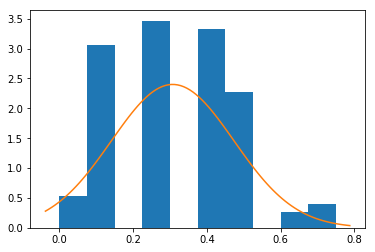

In [419]:
n = 100
# Sin Laplace clasificador Naive-Bayes
bayes = ClasificadorNaiveBayes()
estrategia = ValidacionCruzada(n)

errores = Clasificador.validacion(estrategia, dataset_tic_tac_toe, bayes)

mean = np.mean(errores)
sd = np.std(errores)

plt.hist(errores, density=True)

x = np.linspace(*plt.xlim(), 100)
plt.plot(x, norm.pdf(x,mean, sd))

print("Media de errores {}, Desviacion Tipica {}".format(mean, sd))

Media de errores 0.30875, Desviacion Tipica 0.1745127144365132


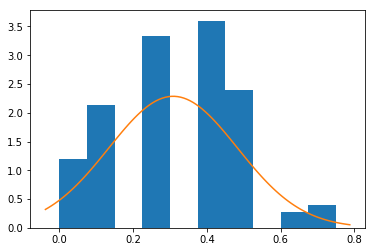

In [420]:
n = 100
# Con Laplace clasificador Naive-Bayes
bayes = ClasificadorNaiveBayes(True)
estrategia = ValidacionCruzada(n)

errores = Clasificador.validacion(estrategia, dataset_tic_tac_toe, bayes)

mean = np.mean(errores)
sd = np.std(errores)

plt.hist(errores, density=True)

plt.plot(x, norm.pdf(x,mean, sd))

print("Media de errores {}, Desviacion Tipica {}".format(mean, sd))

A continuación procedemos a probar Naive Bayes con el conjunto de datos ***german*** y como estrategia de partición utilizaremos una validación Bootstrap con 10 particiones.

Media de errores 0.26774606753605, Desviacion Tipica 0.01671807502980721


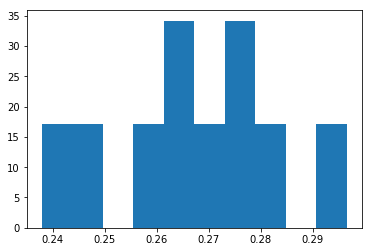

In [425]:
dataset_german = Datos("../ConjuntosDatos/german.Data")

n = 10

# Sin Laplace clasificador Naive-Bayes
bayes = ClasificadorNaiveBayes()
estrategia = ValidacionBootstrap(n)

errores = Clasificador.validacion(estrategia, dataset_german, bayes)

mean = np.mean(errores)
sd = np.std(errores)

plt.hist(errores, density=True)

print("Media de errores {}, Desviacion Tipica {}".format(mean, sd))

Media de errores 0.24373341529823872, Desviacion Tipica 0.01695394947989272


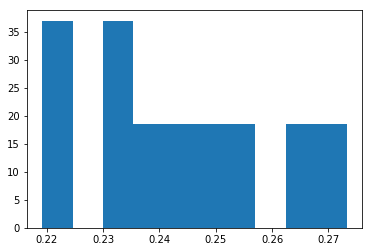

In [426]:
n = 10

# Con Laplace clasificador Naive-Bayes
bayes = ClasificadorNaiveBayes(laplace=True)
estrategia = ValidacionBootstrap(n)

errores = Clasificador.validacion(estrategia, dataset_german, bayes)

mean = np.mean(errores)
sd = np.std(errores)

plt.hist(errores, density=True)

print("Media de errores {}, Desviacion Tipica {}".format(mean, sd))

## Apartado 3 - ScikitLearn
------
En primer lugar crearemos las estrategias de particionado utilizando las funciones implementadas en scikitlearn.
Hemos creado dos funciones para facilitar la llamada utilizando nuestra estructura de datos.

In [443]:
def ValidacionSimpleScikit(datos, porcentaje=.75):
    r"""Devuelve una particion simple con los metodos de sklearn
    
    XTrain, XTest, YTrain, YTest
    """
    # Matriz con atributos 
    X = dataset.datos[:,:-1]
    # Array con clases (ya codificadas)
    y = dataset.datos[:,-1] 
    
    return train_test_split(X, y, train_size = porcentaje, test_size = 1 - porcentaje, shuffle=True)

Probaremos a hacer una partición simple del dataset balloons con un 80% de los datos para entrenamiento.

In [447]:
#Primero encriptamos los atributos

XTrain, XTest, YTrain, YTest = ValidacionSimpleScikit(dataset, porcentaje=.75)

print("Datos entrenamiento\n", XTrain)
print("Datos test\n", XTest)

Datos entrenamiento
 [[1 0 0 1]
 [1 1 1 0]
 [0 1 1 1]
 [1 1 1 1]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [1 0 1 0]
 [1 1 1 0]
 [1 0 1 1]
 [1 1 0 1]
 [0 0 0 1]
 [0 1 1 0]
 [0 1 1 0]]
Datos test
 [[1 0 0 0]
 [0 0 0 0]
 [1 1 0 0]
 [0 1 0 0]
 [0 0 1 1]]


Las clases están guardadas como atributos numéricos, pero podemos decodificarlos

In [452]:
enc = preprocessing.OneHotEncoder(dataset.diccionarios[-1],handle_unknown='ignore')
enc.inverse_transform(YTrain)

AttributeError: 'OneHotEncoder' object has no attribute 'inverse_transform'

In [ ]:

    
#####################################################################################################

    
class ValidacionCruzadaScikit(EstrategiaParticionado):
    """Crea particiones segun el metodo tradicional 
    de division de los datos segun el porcentaje deseado."""
    
    def __init__(self, k=1):
        self.k = k
        super().__init__("Validacion Cruzada Scikit con {} particiones".format(k))

    def creaParticiones(self,datos,seed=None): 
        
        self.numeroParticiones = self.k
        self.particiones = []
            
        #Primero encriptamos los atributos
        encAtributos = preprocessing.OneHotEncoder(categorical_features=datos.nominalAtributos[:-1], sparse=False)
        
        # Guardamos la matriz de atributos codificada
        X = encAtributos.fit_transform(dataset.datos[:,:-1])
        # Guardamos la clase de cada patron
        Y =dataset.datos[:,-1]    

        # Creamos particiones
        kf = KFold(n_splits=self.k, shuffle=True)
        for train, test in kf.split(X, Y):
            XTrain, XTest = X[train], X[test]
            YTrain, YTest = Y[train], Y[test]
            self.particiones.append(Particion(XTrain, XTest))
            self.particiones.append(Particion(YTrain, YTest))
        
        return self.particiones
    
    
class ScikitNaiveBayes(Clasificador):
    
    def entrenamiento(self, datos, indices):
          
        # Calculamos las posteriori de los discretos
        self.NB = nb.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
        # Calculamos NaiveBayes
        self.NB.fit(indices[0], indices[1])
        # indices[0] contiene la particion de datos
        # indices[1] contiene la particion de clases (?) 
        # y en el caso de val.cruzada?

    def clasifica(self, datos, indices):
        
        print(self.NB.predict(indices[0]))    

## Apartado 4 - Curvas Roc

Crearemos una funcion para plotear la curva roc de un clasificador binario y calcular su area bajo la curva, además de las correspondientes matrices de confusión.

In [408]:
def matriz_confusion(clasificador, datos):
    
    r"""Genera matriz de confusion"""
    
    matriz = np.zeros((clasificador.nClases,clasificador.nClases))
    
    pred = clasificador.clasifica(datos)
    clases = datos[:,-1]
    
    for i in range(clasificador.nClases):
        clasei = clases == i
        
        for j in range(clasificador.nClases):
            matriz[j,i] = sum(pred[clasei] == j)
            
    return matriz    

In [409]:
def curva_roc(clasificador, datos, ax=None):
    r"""Genera una curva ROC
    
        Args:
            clasificador(Clasificador): Clasificador ya entrenado
            datos (Datos): Dataset con los datos cargados
            ax: matplotlib axis to plot
        Returns:
            Devuelve el area bajo la curva
    """
    
    
    clases = datos[:,-1]
    
    probabilidades = np.empty(datos.nDatos)
    
    for i, dato in enumerate(datos):
        probabilidades[i] = clasificador.probabilidadClase(dato)[1]
    
    # Ordenamos los indices y clases de acuerdo a la probabilidad de pertenecer a la clase
    indices = np.argsort(probabilidades)
    
    clases = clases[indices]
    
    x = 0
    y = 0
    
    dy = 1. / sum(clases == 0)
    dx = 1. / sum(clases == 1)
    
    puntos_x = np.zeros(len(clases)+1)
    puntos_y = np.zeros(len(clases)+1)
    area = 0
    
    for i, c in enumerate(clases):
        if c == 0:
            y += dy
        else:
            x += dx
            area += y*dx 
        puntos_x[i+1] = x
        puntos_y[i+1] = y
        
        
    if ax is None:
        ax = plt.gca()
        
    ax.plot(puntos_x, puntos_y)
    
    return area

***Curva Roc balloons***

AUC 1.0


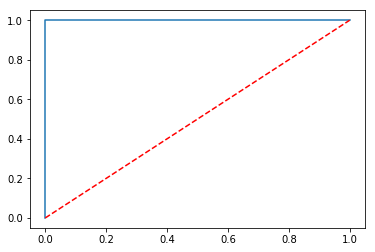

[[12.  0.]
 [ 0.  8.]]


In [410]:
bayes = ClasificadorNaiveBayes()
x = np.linspace(0,1,100)

bayes.entrenamiento(dataset)

area = curva_roc(bayes, dataset)
print("AUC", area)

plt.plot(x,x, c='red', linestyle='dashed')
plt.show()

print(matriz_confusion(bayes, dataset))

***Curva Roc German***

AUC 0.8103666666666727


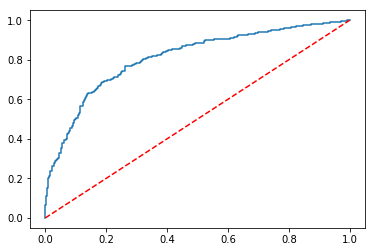

[[609. 137.]
 [ 91. 163.]]


In [411]:
bayes.entrenamiento(dataset_german)

area = curva_roc(bayes, dataset_german)
print("AUC", area)

plt.plot(x,x, c='red', linestyle='dashed')
plt.show()

print(matriz_confusion(bayes, dataset_german))

***Curva ROC Tic Tac Toe***

AUC 0.7685967512221344


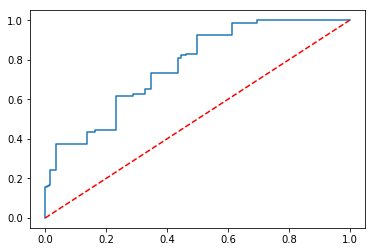

[[148. 105.]
 [184. 521.]]


In [412]:
bayes.entrenamiento(dataset_tic_tac_toe)
area = curva_roc(bayes, dataset_tic_tac_toe)
print("AUC", area)
plt.plot(x,x, c='red', linestyle='dashed')
plt.show()

print(matriz_confusion(bayes, dataset_tic_tac_toe))